In [2]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody

In [3]:
import astropy.units as u
u.solRad.to(u.cm)

69570000000.0

In [4]:
4*np.pi*69570000000.0**2

6.082104402130212e+22

In [5]:
import matplotlib
%matplotlib inline

In [6]:
from phoebe.parameters.dataset import _mesh_columns

In [7]:
b = phoebe.default_binary()
times = np.linspace(0, 24*3600, 10)
COLUMNS = _mesh_columns
b.set_quantity('period@binary', 1)
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.add_dataset('orb', compute_times=times, dataset='orb01')
b.run_compute(irrad_method='none', coordinates='uvw')

100%|██████████| 10/10 [00:00<00:00, 41.50it/s]


<ParameterSet: 637 parameters | kinds: mesh, orb>

In [8]:
from spice.models.phoebe_utils import PhoebeConfig
p1 = PhoebeConfig(b, 'mesh01', 'orb01')

In [9]:
b.get_parameter(qualifier='vus', component='primary', dataset='orb01', kind='orb')

<Parameter: vus=[-134.07073898 -134.07073898 -134.07073898 ...
 -134.07073898 -134.07073898 -134.07073898] km / s | keys: description, value, default_unit, visible_if, required_shape, copy_for, readonly, advanced, latexfmt>

In [10]:
bb = Blackbody()
pm1 = PhoebeModel.construct(p1, times[2], bb.parameter_names, component='primary')
pm2 = PhoebeModel.construct(p1, times[2], bb.parameter_names, component='secondary')

In [11]:
from spice.models.binary import Binary, PhoebeBinary

binary = Binary.from_bodies(pm1, pm2)
pb = PhoebeBinary.construct(p1, 0., bb.parameter_names)

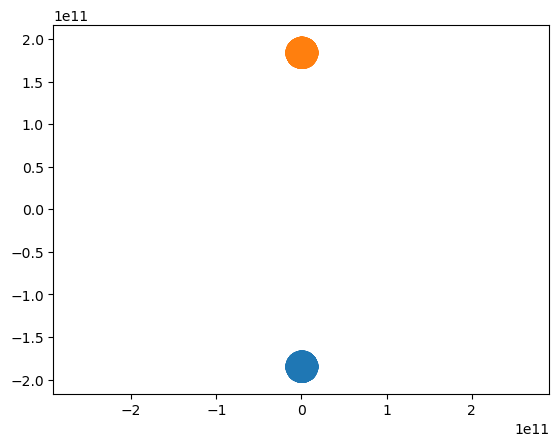

In [12]:
import matplotlib.pyplot as plt

plt.scatter(pb.body1.centers[:, 0], pb.body1.centers[:, 2])
plt.scatter(pb.body2.centers[:, 0], pb.body2.centers[:, 2])

plt.axis('equal')
plt.show()

In [13]:
u.day.to(u.year)

0.0027378507871321013

In [14]:
binary.body1.cast_centers

array([[-2.79350229e+09,  6.88209702e+10, -3.73559869e+11],
       [-5.58699696e+09,  6.88094828e+10, -3.68721396e+11],
       [-2.79349629e+09,  6.88041133e+10, -3.63882915e+11],
       ...,
       [ 2.34092083e+10, -4.05490865e+10, -3.17090197e+11],
       [ 2.40236187e+10, -3.62151903e+10, -3.14113750e+11],
       [ 2.09323093e+10, -3.58184742e+10, -3.12556354e+11]])

In [15]:
binary.body2.cast_centers

array([[ 2.79350229e+09,  6.88209702e+10,  3.73559869e+11],
       [ 5.58699696e+09,  6.88094828e+10,  3.68721396e+11],
       [ 2.79349629e+09,  6.88041133e+10,  3.63882915e+11],
       ...,
       [-2.34092083e+10, -4.05490865e+10,  3.17090197e+11],
       [-2.40236187e+10, -3.62151903e+10,  3.14113750e+11],
       [-2.09323093e+10, -3.58184742e+10,  3.12556354e+11]])

In [16]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
from numpy.typing import ArrayLike
from typing import Tuple, Optional, Union

PLOT_MODES = ['MESH', 'POINTS']
COLORMAP_PROPERTIES = ['mus', 'los_velocities', 'cast_areas']
DEFAULT_PROPERTY = 'mus'

DEFAULT_PLOT_PROPERTY_LABELS = {
    'mus': r'$\mu$',
    'los_velocities': 'LOS velocity [km/s]'
}


def _evaluate_to_be_mapped_property(mesh,
                                    property: Union[str, int] = DEFAULT_PROPERTY,
                                    property_label: Optional[str] = None) -> Tuple[ArrayLike, str]:
    if type(property) is str:
        if property not in COLORMAP_PROPERTIES:
            raise ValueError(f'Invalid property {property} - must be one of ({",".join(COLORMAP_PROPERTIES)})')
        else:
            to_be_mapped = getattr(mesh, property)
        if property_label is None:
            property_label = DEFAULT_PLOT_PROPERTY_LABELS.get(property, '')
    elif type(property) is int:
        if property > mesh.parameters.shape[-1]-1:
            raise ValueError(f'Invalid property index {property} - must be smaller than {mesh.parameters.shape[-1]}')
        else:
            to_be_mapped = mesh.parameters[:, property]
        if property_label is None:
            property_label = ''
    else:
        raise ValueError(f"Property must be either of type str or int")
    
    return to_be_mapped, property_label


def plot_3D_binary(binary,
                    property: Union[str, int] = DEFAULT_PROPERTY,
                    axes: Optional[Tuple[plt.figure, plt.axes]] = None,
                    cmap: str = 'turbo',
                    property_label: Optional[str] = None,
                    mode: str = 'MESH',
                    update_colorbar: bool = True):
    
    if mode.upper() not in PLOT_MODES:
        raise ValueError(f'Mode must be one of ["MESH", "POINTS"]. Got {mode.upper()}')
    mode = mode.upper()
    
    mesh = binary.body1
    to_be_mapped1, cbar_label = _evaluate_to_be_mapped_property(mesh, property, property_label)
    to_be_mapped2, _ = _evaluate_to_be_mapped_property(binary.body2, property, property_label)

    if axes is None:
        fig = plt.figure(figsize=(10, 12))
        spec = fig.add_gridspec(10, 12)
        plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
        plot_ax.view_init(elev=30, azim=60)
    else:
        try:
            fig, plot_ax = axes
        except ValueError:
            raise ValueError("Pass either no axes or (plt.figure, plt.axes, plt.axes) for the plot axis and colorbar axis")
    max_orbit = np.max(np.abs((binary.body1.centers) - (binary.body2.centers)))
    axes_lim = 1.05*max_orbit
    plot_ax.set_xlim3d(-axes_lim, axes_lim)
    plot_ax.set_ylim3d(-axes_lim, axes_lim)
    plot_ax.set_zlim3d(-axes_lim, axes_lim)
    plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)

    normalized_los_vector = mesh.los_vector/np.linalg.norm(mesh.los_vector)
    normalized_rotation_axis = mesh.rotation_axis/np.linalg.norm(mesh.rotation_axis)

    plot_ax.quiver(*(-1.1*axes_lim*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                   color='red', linewidth=3., label='LOS vector')
    plot_ax.legend()

    all_mapped = np.concatenate([to_be_mapped1, to_be_mapped2])
    norm = mpl.colors.Normalize(vmin=all_mapped.min(), vmax=all_mapped.max())
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

    if mode == 'MESH':
        vs2 = mesh.vertices
        face_colors = mpl.colormaps[cmap](norm(to_be_mapped1))
        p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black")
        plot_ax.add_collection(p)
        p2 = art3d.Poly3DCollection(binary.body2.vertices, facecolors=mpl.colormaps[cmap](norm(to_be_mapped2)), edgecolor="black")
        plot_ax.add_collection(p2)
        mappable.set_array([])
    else:
        p = plot_ax.scatter(mesh.centers[:, 0], mesh.centers[:, 1], mesh.centers[:, 2],
                            c=to_be_mapped1, cmap=cmap, norm=norm)
        
    if update_colorbar:
        cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)
        cbar.set_label(cbar_label, fontsize=12)

    return fig, plot_ax

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>)

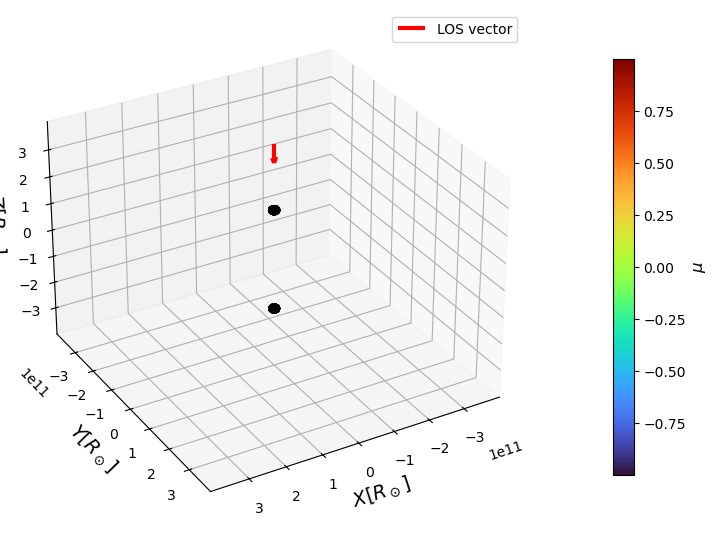

In [17]:
plot_3D_binary(binary)

In [16]:
ws = np.linspace(4000, 10000, 1000)
s = simulate_spectrum(b.intensity, pm, np.log10(ws))

AttributeError: 'Bundle' object has no attribute 'intensity'

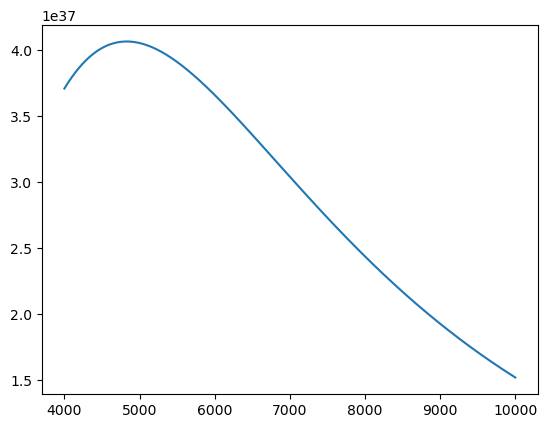

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ws, s[:, 0])

In [ ]:
from spice.plots import plot_3D
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d

Is the rotation axis and LOS vector reversed actually?

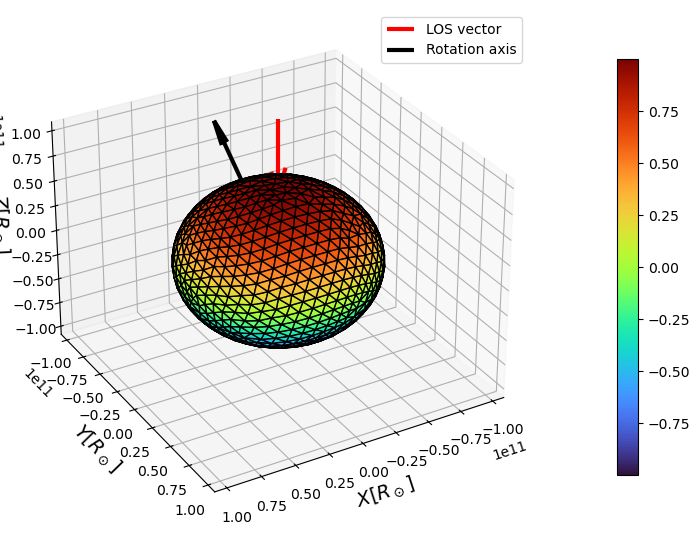

In [ ]:
fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
plot_ax.view_init(elev=30, azim=60)
axes_lim = 1.5*pm.radius
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
normalized_los_vector = pm.los_vector/np.linalg.norm(pm.los_vector)
normalized_rotation_axis = pm.rotation_axis/np.linalg.norm(pm.rotation_axis)
mesh=pm
plot_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                   color='red', linewidth=3., label='LOS vector')
plot_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                color='black', linewidth=3., label='Rotation axis')
plot_ax.legend()
vs2 = mesh.cast_vertices
to_be_mapped = pm.mus
norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap='turbo', norm=norm)
face_colors = mpl.colormaps['turbo'](norm(to_be_mapped))
p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black")
plot_ax.add_collection(p)
mappable.set_array([])
cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)

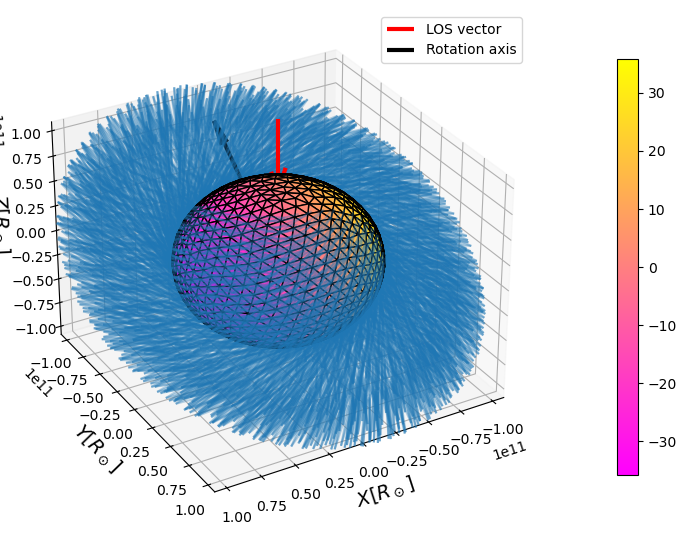

In [ ]:
fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
plot_ax.view_init(elev=30, azim=60)
axes_lim = 1.5*pm.radius
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
normalized_los_vector = pm.los_vector/np.linalg.norm(pm.los_vector)
normalized_rotation_axis = pm.rotation_axis/np.linalg.norm(pm.rotation_axis)
mesh=pm
plot_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                   color='red', linewidth=3., label='LOS vector')
plot_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                color='black', linewidth=3., label='Rotation axis')
plot_ax.legend()
vs2 = mesh.cast_vertices
to_be_mapped = pm.los_velocities
norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap='spring', norm=norm)
face_colors = mpl.colormaps['spring'](norm(to_be_mapped))
c = pm.centers
v = pm.center_velocities
for cc, vv in zip(c, v):
    plot_ax.quiver(*(cc), *(0.04*mesh.radius*vv), alpha=0.3)
p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black")
plot_ax.add_collection(p)
mappable.set_array([])
cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)

In [ ]:
pm.rotation_axis

array([ 0.        , -0.70710678,  0.70710678])

In [ ]:
np.rad2deg(np.arcsin(pm.rotation_axis[1]))

-44.99999999999999

In [ ]:
pm.rotation_velocity

50.59273169218562

In [ ]:
pm.radius/u.solRad.to(u.cm)

1.0